<a href="https://colab.research.google.com/github/SatoSim/xray_project/blob/main/Final_Project_X_Ray_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


* Plan X-Ray Image analysis

  - For this project I will be creating a CNN model that will predict if a patient has pneumonia.

  - I will be using the Kaggle data set that contains 5800 x-ray scans.

 - I will need to normalize the data, do data augmentation, rescale the images, split the data into training and testing after transformation and scaling.
  - For EDA I will take a look at the proportion of "NORMAL" and "PNEUMONIA" images, I will also check how the images look like.
      - I will perform PCA to reduce the dimensions of the images. This will allow me to visualize and tune the number of dimensions necessary to differentiate images.
      - I will use k means to cluster the new features to corroborate that the number of new dimensions its appropriate.
  - For model selection, I will use a Convolutional Neural Network. Possibly PCA for dimensionality reduction. I will also test a MLPClassifier to compare results with CNN. I am choosing these algorithms since I can perfomr supervised machine learning and it is a classification problem.
  - I will perform tuning grids and hyperparameter tuning to improve the models during training.
  - I will evaluate the models using metrics such as accuracy, precision, recall.

  Links to other sources and notebooks used as reference to build this project.
  - Example of CNN used to evaluate same pneumonia data set
   https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy/notebook

  -

#EXTRACTING IMAGES FROM GIT REPO

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import cv2
import os

import shutil
import requests
from zipfile import ZipFile
import pickle
import zipfile
from google.colab import files



In [ ]:
!git clone https://github.com/SatoSim/xray_project.git
repo_path = "/content/xray_project"
train_path = os.path.join(repo_path, "train")
test_path = os.path.join(repo_path, "test")

Cloning into 'xray_project'...
remote: Enumerating objects: 5858, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 5858 (delta 0), reused 2 (delta 0), pack-reused 5856
Receiving objects: 100% (5858/5858), 1.16 GiB | 20.13 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (5857/5857), done.


In [ ]:
def download_and_extract(url, target_path):
    r = requests.get(url)
    with open('xray_project.zip', 'wb') as f:
        f.write(r.content)
    with ZipFile('xray_project.zip', 'r') as zip_ref:
        zip_ref.extractall(target_path)
    os.remove('xray_project.zip')

# Download and extract train images
train_url = "https://github.com/SatoSim/xray_project/archive/main.zip"
download_and_extract(train_url, repo_path)

# Download and extract test images
test_url = "https://github.com/SatoSim/xray_project/archive/main.zip"
download_and_extract(test_url, repo_path)




# Verify the images are copied
print("Train images copied successfully to Colab environment.")
print("Test images copied successfully to Colab environment.")


Train images copied successfully to Colab environment.
Test images copied successfully to Colab environment.


In [ ]:
# Move train images to Colab environment
train_normal_path = os.path.join(train_path, "NORMAL")
train_pneumonia_path = os.path.join(train_path, "PNEUMONIA")
train_normal_dest = "/content/train/NORMAL"
train_pneumonia_dest = "/content/train/PNEUMONIA"
shutil.move(train_normal_path, train_normal_dest)
shutil.move(train_pneumonia_path, train_pneumonia_dest)

# Move test images to Colab environment
test_normal_path = os.path.join(test_path, "NORMAL")
test_pneumonia_path = os.path.join(test_path, "PNEUMONIA")
test_normal_dest = "/content/test/NORMAL"
test_pneumonia_dest = "/content/test/PNEUMONIA"
shutil.move(test_normal_path, test_normal_dest)
shutil.move(test_pneumonia_path, test_pneumonia_dest)

'/content/test/PNEUMONIA'

In [ ]:
train_normal_dest = "/content/train/NORMAL"
train_pneumonia_dest = "/content/train/PNEUMONIA"
test_pneumonia_path = os.path.join(test_path, "PNEUMONIA")
test_normal_dest = "/content/test/NORMAL"
test_pneumonia_dest = "/content/test/PNEUMONIA"

Visualizing resized images from the train set:


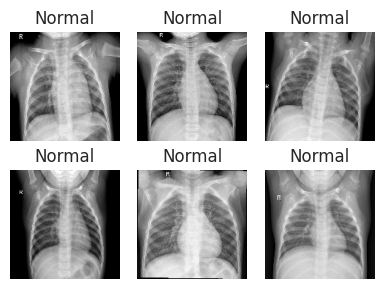

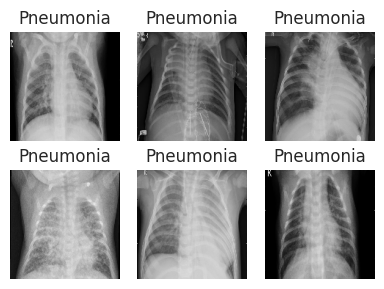

Visualizing resized images from the test set:


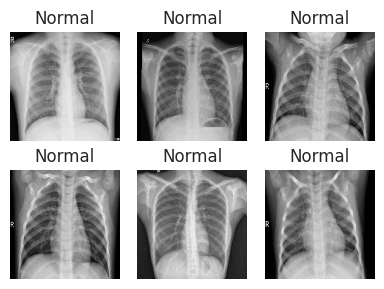

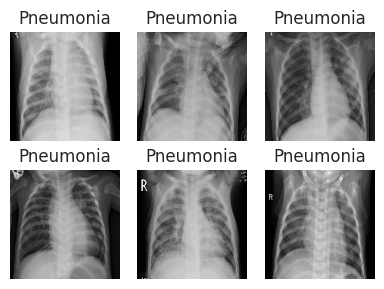

In [ ]:
def display_images_grid(folder_path, num_rows=2, num_cols=3, image_size=(150, 150)):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4, 3))
    image_files = os.listdir(folder_path)
    for i in range(num_rows):
        for j in range(num_cols):
            image_path = os.path.join(folder_path, image_files[i * num_cols + j])
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            image_resized = cv2.resize(image, image_size)  # Resize the image
            axes[i, j].imshow(image_resized)
            axes[i, j].axis('off')
            if "NORMAL" in folder_path:
                axes[i, j].set_title("Normal")
            else:
                axes[i, j].set_title("Pneumonia")
    plt.tight_layout()
    plt.show()

print("Visualizing resized images from the train set:")
display_images_grid(train_normal_dest)
display_images_grid(train_pneumonia_dest)

print("Visualizing resized images from the test set:")
display_images_grid(test_normal_dest)
display_images_grid(test_pneumonia_dest)


#Loading Images as numpy arrays

In [ ]:
def load_images(train_normal_path, train_pneumonia_path, test_normal_path, test_pneumonia_path, image_size=(150, 150)):
    def load_images_from_folder(folder_path):
        images = []
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, image_size)
                if img is not None:
                    images.append(img)
            except Exception as e:
                print(f"Error loading image: {img_path} - {e}")
        return images

    train_normal_images = load_images_from_folder(train_normal_path)
    train_pneumonia_images = load_images_from_folder(train_pneumonia_path)

    test_normal_images = load_images_from_folder(test_normal_path)
    test_pneumonia_images = load_images_from_folder(test_pneumonia_path)

    train_normal_array = np.array(train_normal_images)
    train_pneumonia_array = np.array(train_pneumonia_images)
    test_normal_array = np.array(test_normal_images)
    test_pneumonia_array = np.array(test_pneumonia_images)

    return train_normal_array, train_pneumonia_array, test_normal_array, test_pneumonia_array

train_normal_array, train_pneumonia_array, test_normal_array, test_pneumonia_array = load_images(train_normal_dest, train_pneumonia_dest, test_normal_dest, test_pneumonia_dest)

print("Train normal images array shape:", train_normal_array.shape)
print("Train pneumonia images array shape:", train_pneumonia_array.shape)
print("Test normal images array shape:", test_normal_array.shape)
print("Test pneumonia images array shape:", test_pneumonia_array.shape)


Error loading image: /content/train/NORMAL/.DS_Store - OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

Train normal images array shape: (1349, 150, 150, 3)
Train pneumonia images array shape: (3883, 150, 150, 3)
Test normal images array shape: (234, 150, 150, 3)
Test pneumonia images array shape: (390, 150, 150, 3)


# EDA

In [ ]:

print("Train normal images array shape:", train_normal_array.shape)
print("Train pneumonia images array shape:", train_pneumonia_array.shape)
print("Test normal images array shape:", test_normal_array.shape)
print("Test pneumonia images array shape:", test_pneumonia_array.shape)


Train normal images array shape: (1349, 150, 150, 3)
Train pneumonia images array shape: (3883, 150, 150, 3)
Test normal images array shape: (234, 150, 150, 3)
Test pneumonia images array shape: (390, 150, 150, 3)


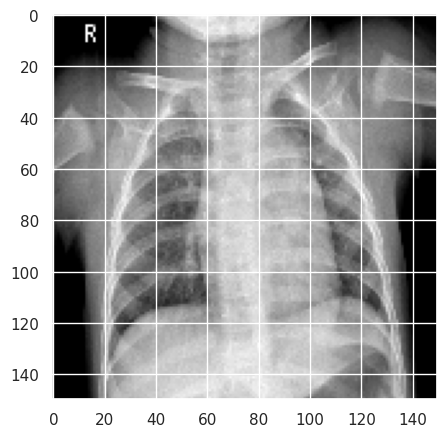

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train_normal_array[0], cmap='gray')


#Getting a balanced df from the data

In [ ]:
normal_data_train = [("NORMAL", img) for img in train_normal_array]
normal_data_test = [("NORMAL", img) for img in test_normal_array]

all_normal_data = normal_data_test + normal_data_train # All normal as nparrays

penumonia_data_train = [("PNEUMONIA", img) for img in train_pneumonia_array]
pneumonia_data_test = [("PNEUMONIA", img) for img in test_pneumonia_array]

all_pneumonia_data = penumonia_data_train + pneumonia_data_test # All pneumonia as nparrays


In [ ]:
df_normal_data = pd.DataFrame(all_normal_data, columns=["Label", "Image_Array"])
df_pneumonia_data = pd.DataFrame(all_pneumonia_data, columns=["Label", "Image_Array"])


In [ ]:
df_normal_data.head()

,Label,Image_Array
0,NORMAL,"[[[17, 17, 17], [18, 18, 18], [18, 18, 18], [1..."
1,NORMAL,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,NORMAL,"[[[80, 80, 80], [117, 117, 117], [161, 161, 16..."
3,NORMAL,"[[[22, 22, 22], [28, 28, 28], [34, 34, 34], [3..."
4,NORMAL,"[[[58, 58, 58], [61, 61, 61], [70, 70, 70], [6..."


In [ ]:
print(df_normal_data.shape)
print(df_pneumonia_data.shape)


(1583, 2)
(4273, 2)


# CODE TO OBTAIN A DF WITH ALL THE IMAGES

In [ ]:
# ALL THE DATA COMBINED

train_data = [("NORMAL", img) for img in train_normal_array] + [("PNEUMONIA", img) for img in train_pneumonia_array] #Attaching label to train data
test_data = [("NORMAL", img) for img in test_normal_array] + [("PNEUMONIA", img) for img in test_pneumonia_array]
all_data = train_data + test_data
df = pd.DataFrame(all_data, columns=["Label", "Image_Array"])



<Axes: xlabel='count'>

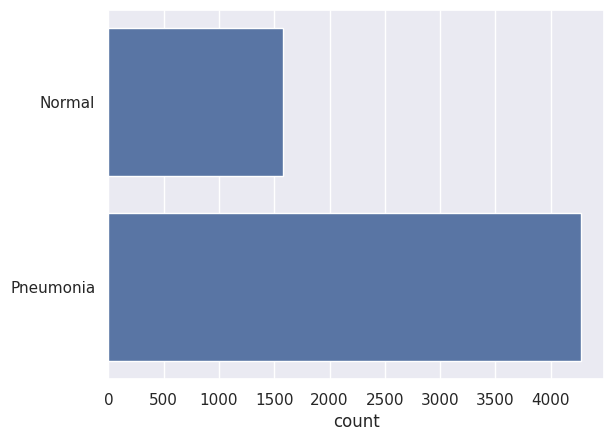

In [ ]:
df["Label"].value_counts()
l = []
for i in df["Label"]:
    if(i == "PNEUMONIA"):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.countplot(l)

# Data Cleaning


# Code to obtain a dataframe that is balanced. i.e contains same number of normal and penumonia images.


In [ ]:
# Data frames to download.
# df_normal_data  - 1583
# df_pneumonia_data - 4273

In [ ]:
# Normalizing dataframes
df_normal_data["norm"] = df_normal_data["Image_Array"]/255
df_pneumonia_data["norm"] = df_pneumonia_data["Image_Array"]/255

# Mapping labels to 0 - 1
mapping = {"NORMAL": 0, "PNEUMONIA": 1}
df_normal_data['Label'] = df_normal_data['Label'].map(mapping)
df_pneumonia_data['Label'] = df_pneumonia_data['Label'].map(mapping)

# Flattening images
df_normal_data["flattened"] = [img.flatten() for img in df_normal_data['norm']]
df_pneumonia_data["flattened"] = [img.flatten() for img in df_pneumonia_data['norm']]


In [ ]:
print(df_normal_data.shape)
df_normal_data.head()

In [ ]:
print(df_pneumonia_data.shape)
df_pneumonia_data.head()

# Downloading the two dataframes

In [ ]:
num_rows_to_keep = 1583 # We use 1583 since it is the number of normal images.

df_normal_tosave = df_normal_data.filter(['Label','flattened'], axis=1)
df_normal_reduced = df_normal_tosave.head(num_rows_to_keep).copy()

In [ ]:
data = df_normal_reduced
with open("df_normal.pkl", "wb") as f:
    pickle.dump(data, f)

with zipfile.ZipFile("df_normal.zip", "w", compression=zipfile.ZIP_DEFLATED) as zipf:
    zipf.write("df_normal.pkl")
files.download("df_normal.zip")

In [ ]:
num_rows_to_keep = 1583 # We use 1583 since it is the number of normal images.

df_pneumonia_tosave = df_pneumonia_data.filter(['Label','flattened'], axis=1)
df_pneumonia_reduced = df_pneumonia_tosave.sample(n=num_rows_to_keep, random_state=5)


In [ ]:
data = df_pneumonia_reduced
with open("df_pneumonia3.pkl", "wb") as f:
    pickle.dump(data, f)

with zipfile.ZipFile("df_pneumonia3.zip", "w", compression=zipfile.ZIP_DEFLATED) as zipf:
    zipf.write("df_pneumonia3.pkl")
files.download("df_pneumonia3.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>